<h2>CS 4780/5780 Final Project: </h2>
<h3>COVID-19 Hospitalizations Prediction for EU Countries</h3>

Deepa Korani (dmk333), Harshwardhan Praveen (hp447)

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is predicting hospitalizations due to COVID-19. Although hospitalizations are directly related to COVID-19 cases, the different populations, timelines and reactionary measures of different EU countries result in different trends in hospitalization numbers. In this project you will bring the power of machine learning to make predictions for the country-level hospitalizations using COVID-19 age group case data and also previous hospitalization data. There will be two tasks, one will be a basic problem that will require you to use methods learned in class. The second task will be more difficult and will require some additional intuition and insight. <b>Please read the project description PDF file carefully and follow the instructions there. Also make sure you write your code and answers to all the questions in this Jupyter Notebook </b> </p>
<p>


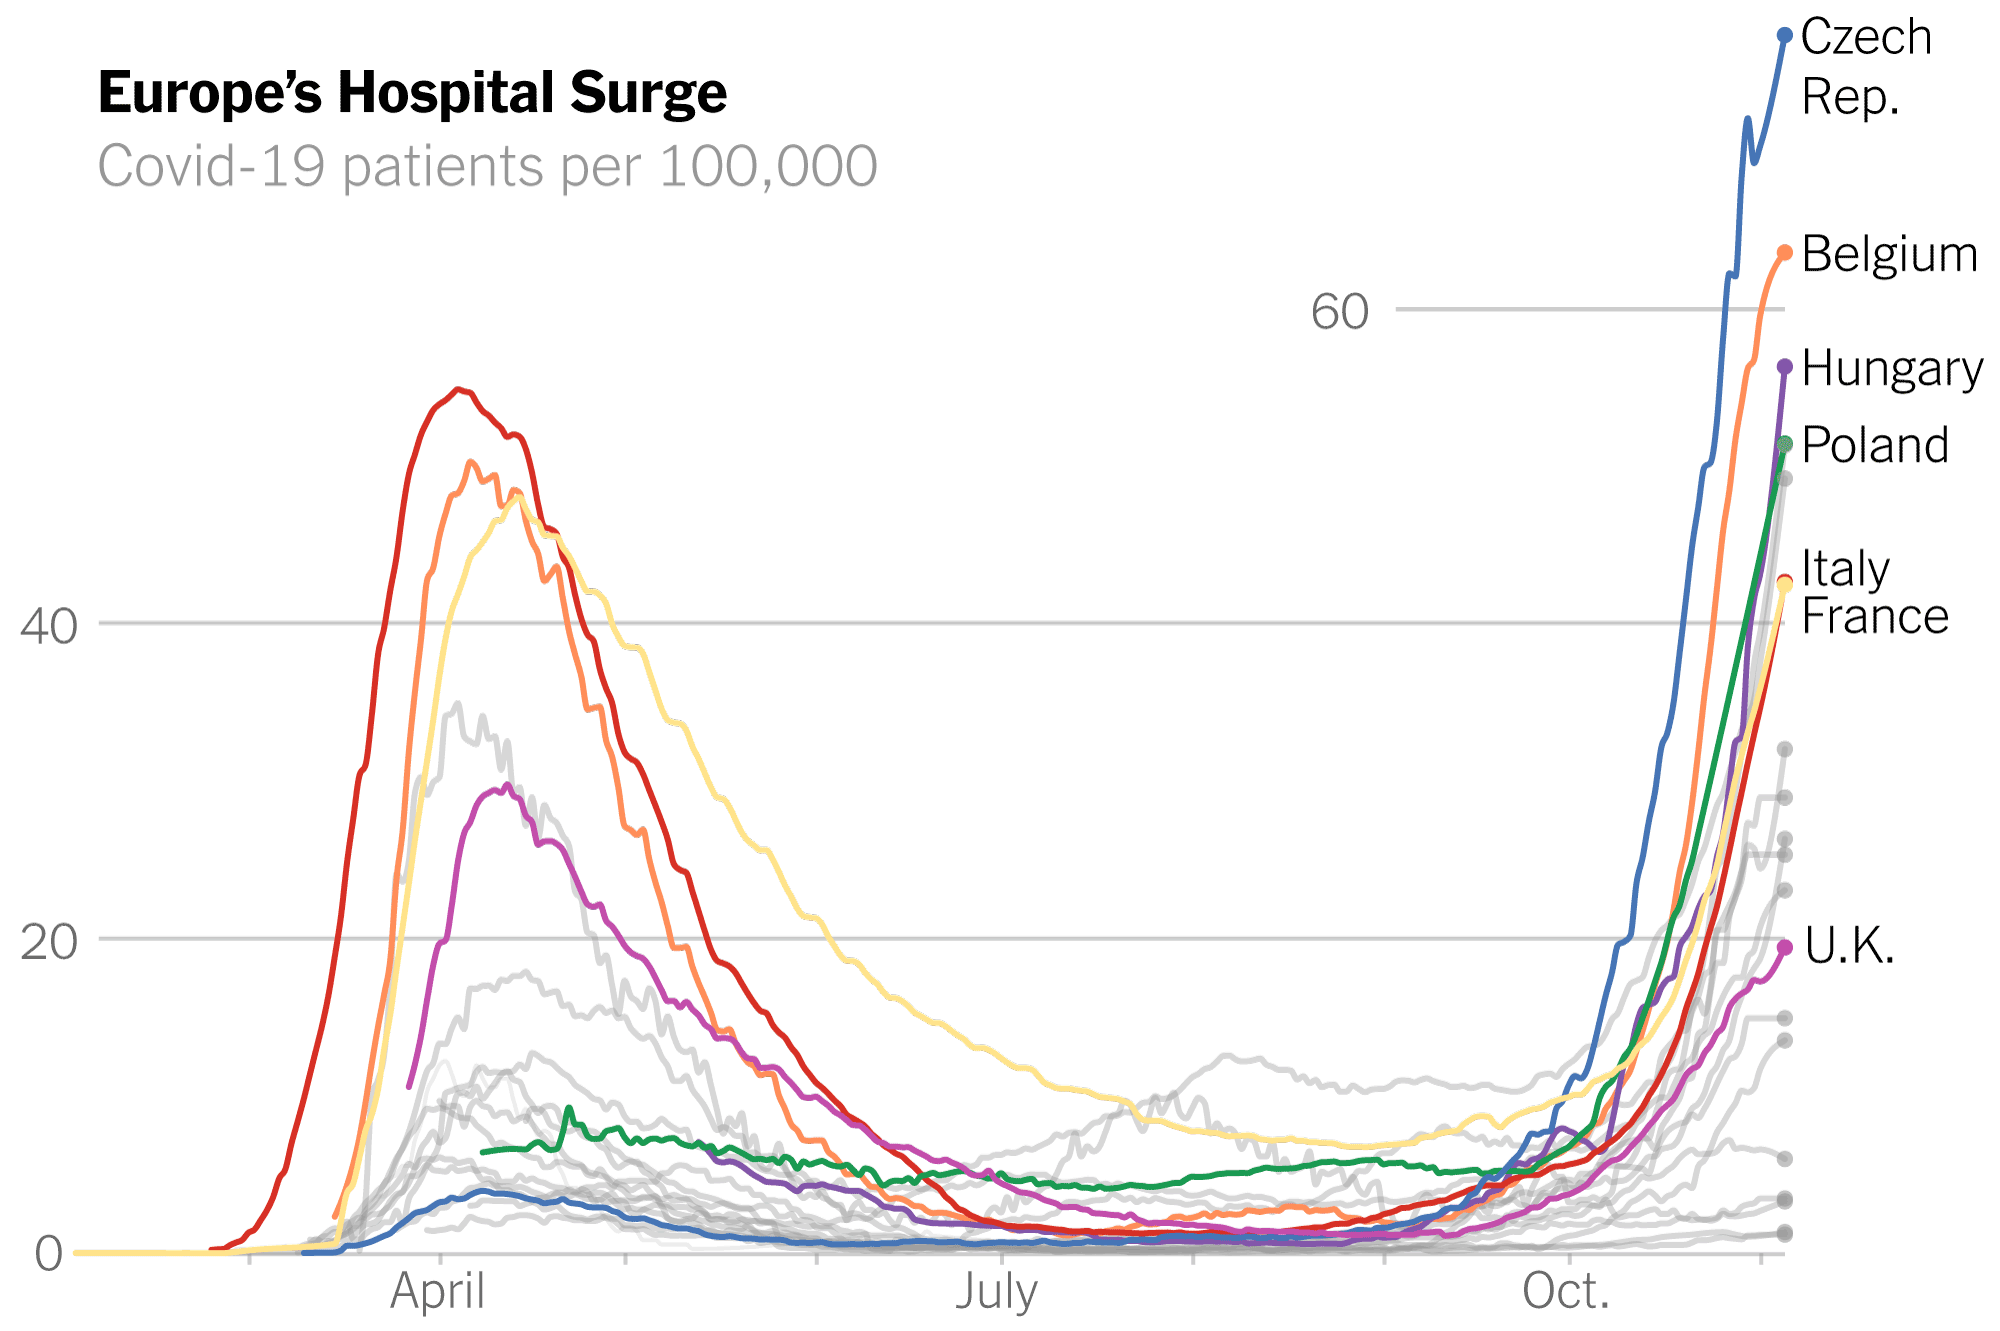

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

print(tf.__version__)
%matplotlib widget

2.2.0


<h3>1.2 Accuracy and Mean Squared Error:</h3><p>
To measure your performance in the Kaggle Competition, we are using accuracy and mean squared error (MSE). As a recap, accuracy is the percent of labels you predict correctly and MSE is the average squared difference between the estimated values and the actual value. To measure this, you can use library functions from sklearn. A simple example is shown below. 
<p>

In [2]:
from sklearn.metrics import accuracy_score
y_pred = [3, 2, 1, 0, 1, 2, 3]
y_true = [0, 1, 2, 3, 1, 2, 3]
accuracy_score(y_true, y_pred)

0.42857142857142855

In [3]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true, y_pred)

2.857142857142857

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). Think of what modifications can be done to the data to make it more easily interpretable.
<p>

In [60]:
def load_and_preprocess_data(data_path, predict_path):
    def common_preprocess(data, epoch):
        
        data = data.rename(columns={'Daily hospital occupancy': 'daily_hospital_occupancy'})
    
        # Defining the date encoding as the number of days elapsed since a given epoch (choice of epoch doesn't matter)
        data['date'] = pd.to_datetime(data['date'])
        data['date_encoding'] = (data['date']-epoch).dt.days
        
        # Drop the date and year_week column
        data = data.drop(['date'], axis=1)
        data = data.drop(['year_week'], axis=1)
        
        return data
    
    # Load the features and t_values for the data with known target values
    data = pd.read_csv(data_path)
    epoch = pd.to_datetime(data['date']).min()  # Choose an epoch
    
    # Preprocess the data
    df = common_preprocess(data, epoch)
    
    # Load the data on which the predictions are to be made
    predict_data = pd.read_csv(predict_path)
    index = predict_data['country'] + ' ' + predict_data['date']  # Store the index for making the csv for submission to kaggle
    
    # Process the data in the same way as the training data
    predict_df = common_preprocess(predict_data, epoch)
    
    return index, df, predict_df

<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

## Neural Network

In [61]:
index, df, pdf = load_and_preprocess_data('train_baseline.csv', 'test_baseline_no_label.csv')

# Define the categorical and numerical columns for tensorflow
CATEGORICAL_COLUMNS = df.columns[0:1].to_numpy().astype('object').tolist()
NUMERIC_COLUMNS = df.columns[1:].to_numpy().tolist()
NUMERIC_COLUMNS.remove('next_week_increase_decrease')

# Normalize the numerical columns
scaler = StandardScaler()
df[NUMERIC_COLUMNS] = scaler.fit_transform(df[NUMERIC_COLUMNS]) # Learn the mean and std and nomalize
pdf[NUMERIC_COLUMNS] = scaler.transform(pdf[NUMERIC_COLUMNS]) # Use the learned mean and std to normalize the prediction dataset


# Generate the final data frame and the labels
data = df[CATEGORICAL_COLUMNS + NUMERIC_COLUMNS]
pdata = pdf[CATEGORICAL_COLUMNS + NUMERIC_COLUMNS]
y = df['next_week_increase_decrease']

In [62]:
# Split the data into training and validation sets. Using a fixed random_seed for consistency across models

seed = 42

train_ratio = 0.7

x_train, x_val, y_train, y_val = train_test_split(data, y, test_size = 1 - train_ratio, random_state = seed)

In [24]:
# Tensorflow takes a tensorflow dataset for it's models
def create_tf_df(df, labels, shuffle = True, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(df))
    ds = ds.batch(batch_size)
    return ds

def create_pdf(df, batch_size = 1):
    ds = tf.data.Dataset.from_tensor_slices(dict(pdf))
    ds = ds.batch(batch_size)
    return ds
    
batch_size = 40

# Define the tensorflow datasets
train_df = create_tf_df(x_train, y_train, shuffle = False, batch_size = batch_size)
val_df = create_tf_df(x_val, y_val, shuffle = False, batch_size = batch_size)
pdf_df = create_pdf(pdf)

In [42]:
feature_columns = []

# Define the feature columns for creating a tensorflow.keras features layer
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = data[feature_name].unique()
    feature_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype = tf.float64))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Define the learning rate for the optimizer
lr = 0.001

# Create a neural network with l1 l2 regularization using tf.keras.Sequential

model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0, l2=0.01)),
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0, l2=0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Define the optimizer for learning the weights of the define model
optimizer = tf.optimizers.RMSprop(learning_rate = lr)

# Compile the tensorflow model with a mean squared error loss
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

In [43]:
# Fit the model on the training set and check against the validation set
history = model.fit(train_df, validation_data = val_df, epochs = 200)

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

70/70 [==============================] - 1s 7ms/step - loss: 1.0077 - accuracy: 0.5697 - val_loss: 0.9289 - val_accuracy: 0.6087
Epoch 2/200
70/70 [==============================] - 0s 5ms/step - loss: 0.8727 - accuracy: 0.6221 - val_loss: 0.8236 - val_accuracy: 0.6229
Epoch 3/200
70/70 [==============================] - 0s 6ms/step - loss: 0.7870 - accuracy: 0.6271 - val_loss: 0.7559 - val_accuracy: 0.6212
Epoch 4/200
70/70 [==============================] - 1s 7ms/step - loss: 0.7318 - acc

In [44]:
# Plot the mse error over time
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model mean squared error')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
# Make the prediction on the prediction dataset and write them to a csv file
pred = model.predict(pdf_df)
pred = np.where(pred > 0.5, 1, 0)
submit = {'country_id': index, 'next_week_increase_decrease':pred.astype(int).flatten()}
sdf = pd.DataFrame(data = submit)
sdf.to_csv('submit_baseline_neural.csv',index = False)

## Adaboost

In [83]:
index, df, pdf = load_and_preprocess_data('train_baseline.csv', 'test_baseline_no_label.csv')

# Encode the country column with one-hot encoding
def one_hot_encoding(df):
    encoded_columns = pd.get_dummies(df['country'])
    df = df.join(encoded_columns).drop('country', axis=1)
    return df

df = one_hot_encoding(df)
pdf = one_hot_encoding(pdf)

# Normalize the numerical columns
NUMERICAL_FEATURES = ['daily_hospital_occupancy','under_15_cases','15-24_cases','25-49_cases','50-64_cases','65-79_cases','over_80_cases', 'date_encoding']

scaler = StandardScaler()
df[NUMERIC_COLUMNS] = scaler.fit_transform(df[NUMERIC_COLUMNS]) # Learn the mean and std and nomalize
pdf[NUMERIC_COLUMNS] = scaler.transform(pdf[NUMERIC_COLUMNS]) # Use the learned mean and std to normalize the prediction dataset

y = df['next_week_increase_decrease']
df = df.drop(['next_week_increase_decrease'], axis = 1)

feature_names = [f'{i}' for i in df.columns]
#final_features = feature_names[0:29]
X = df.iloc[:,:].values
y = y.values

In [91]:
# Define the model
model = AdaBoostClassifier(n_estimators =20,random_state = 0,learning_rate = 1)
model.fit(X,y)

print(f'Training accuracy: {model.score(X,y)}')

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print(f'Validataion Accuracy: {mean(n_scores)} ({std(n_scores)})')

Training accuracy: 0.7751568381430364
Validataion Accuracy: 0.7701191109085845 (0.03607671436903499)


In [92]:
pred = model.predict(pdf)
submit = {'country_id': index, 'next_week_increase_decrease':pred.astype(int).flatten()}
sdf = pd.DataFrame(data = submit)
sdf.to_csv('submit_baseline_adaboost.csv',index = False)

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features, and how did you formulate the learning problem (or problems)?

2.4.2 Which two learning methods from class did you choose and why did you made the choices?

2.4.3 How did you do the model selection?

2.4.4 Does the test performance reach a given baseline 70% performance? (Please include a screenshot of Kaggle Submission)

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating/using new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 150k MSE creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [9]:
def load_and_preprocess_data(data_path, t_data_path, predict_path, t_predict_path, t_values = 0):
    def common_preprocess(data, t_data, epoch):
        
        for i in range(1,t_values+1):
            data['value_t-'+str(i)] = data['Daily hospital occupancy'] - t_data['value_t-'+str(i)]          # Use increase in hospitalization numbers instead of using t_values directly
        
        data = data.rename(columns={'Daily hospital occupancy': 'daily_hospital_occupancy'})
    
        # Defining the date encoding as the number of days elapsed since a given epoch (choice of epoch doesn't matter)
        data['date'] = pd.to_datetime(data['date'])
        print(epoch)
        data['date_encoding'] = (data['date']-epoch).dt.days
        
        # Drop the date and year_week column
        data = data.drop(['date'], axis=1)
        data = data.drop(['year_week'], axis=1)
        
        return data
    
    # Load the features and t_values for the data with known target values
    data = pd.read_csv(data_path)
    t_data = pd.read_csv(t_data_path)
    epoch = pd.to_datetime(data['date']).min()  # Choose an epoch
    
    # Preprocess the data
    df = common_preprocess(data, t_data, epoch)
    
    # Load the data on which the predictions are to be made
    predict_data = pd.read_csv(predict_path)
    index = predict_data['country'] + ' ' + predict_data['date']  # Store the index for making the csv for submission to kaggle
    t_predict_data = pd.read_csv(t_predict_path)
    
    # Process the data in the same way as the training data
    predict_df = common_preprocess(predict_data, t_predict_data, epoch)
    
    return index, df, predict_df

In [10]:
t_values = 7
index, df, pdf = load_and_preprocess_data('train_creative.csv', 'train_creative_t_values.csv', 'test_creative_no_label.csv', 'test_creative_t_values.csv', t_values)

# Define the categorical and numerical columns for tensorflow
CATEGORICAL_COLUMNS = df.columns[0:1].to_numpy().astype('object').tolist()
NUMERIC_COLUMNS = df.columns[1:].to_numpy().tolist()
NUMERIC_COLUMNS.remove('next_week_hospitalizations')

# Normalize the numerical columns
scaler = StandardScaler()
df[NUMERIC_COLUMNS] = scaler.fit_transform(df[NUMERIC_COLUMNS]) # Learn the mean and std and nomalize
pdf[NUMERIC_COLUMNS] = scaler.transform(pdf[NUMERIC_COLUMNS]) # Use the learned mean and std to normalize the prediction dataset


# Generate the final data frame and the labels
data = df[CATEGORICAL_COLUMNS + NUMERIC_COLUMNS]
pdata = pdf[CATEGORICAL_COLUMNS + NUMERIC_COLUMNS]
y = df['next_week_hospitalizations']

2020-02-12 00:00:00
2020-02-12 00:00:00


In [11]:
# Split the data into training and validation sets. Using a fixed random_seed for consistency across models

seed = 42

train_ratio = 0.7

x_train, x_val, y_train, y_val = train_test_split(data, y, test_size = 1 - train_ratio, random_state = seed)

In [12]:
# Tensorflow takes a tensorflow dataset for it's models
def create_tf_df(df, labels, shuffle = True, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(df))
    ds = ds.batch(batch_size)
    return ds

def create_pdf(df, batch_size = 1):
    ds = tf.data.Dataset.from_tensor_slices(dict(pdf))
    ds = ds.batch(batch_size)
    return ds
    
batch_size = 40

# Define the tensorflow datasets
train_df = create_tf_df(x_train, y_train, shuffle = False, batch_size = batch_size)
val_df = create_tf_df(x_val, y_val, shuffle = False, batch_size = batch_size)
pdf_df = create_pdf(pdf)

In [13]:
feature_columns = []

# Define the feature columns for creating a tensorflow.keras features layer
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = data[feature_name].unique()
    feature_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype = tf.float64))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Define a learning rate schedule for the optimizer
initial_lr = 0.001

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_lr,
#     decay_steps = 100000,
#     decay_rate = 0.96,
#     staircase = True)

# Create a neural network with l1 l2 regularization using tf.keras.Sequential

model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.2, l2=0.01)),
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.2, l2=0.01)),
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.2, l2=0.01)),
    tf.keras.layers.Dense(1)
])

# Define the optimizer for learning the weights of the define model
optimizer = tf.optimizers.RMSprop(learning_rate = initial_lr)

# Compile the tensorflow model with a mean squared error loss
model.compile(loss = 'mse',
              optimizer = optimizer,
              metrics=['mse'])

In [14]:
# Fit the model on the training set and check against the validation set
history = model.fit(train_df, validation_data = val_df, epochs = 1500)

Epoch 1/1500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

70/70 [==============================] - 1s 14ms/step - loss: 41423348.0000 - mse: 41423292.0000 - val_loss: 38926348.0000 - val_mse: 38926300.0000
Epoch 2/1500
70/70 [==============================] - 1s 9ms/step - loss: 41328672.0000 - mse: 41328628.0000 - val_loss: 38777320.0000 - val_mse: 38777268.0000
Epoch 3/1500
70/70 [==============================] - 1s 10ms/step - loss: 41047432.0000 - mse: 41047380.0000 - val_loss: 38387580.0000 - val_mse: 38387532.0000
Epoch 4/1500
70/70 [======

In [15]:
# Plot the mse error over time
plt.figure()
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
# Make the prediction on the prediction dataset and write them to a csv file
pred = model.predict(pdf_df)
submit = {'country_id': index, 'next_week_hospitalizations':pred.astype(int).flatten()}
sdf = pd.DataFrame(data = submit)
sdf.to_csv('submit_creative.csv',index = False)

<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set? Did you reach the 150k MSE for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

<hr>

We did manage to do fairly well on the public section of the test set. THe screenshot for the Kaggle submission is attached here:

![](kaggle_creative.png)

We decided to work with a Deep Neural network for the creative part of the problem because they can represent a wide variety of interesting functions when given appropriate weights and architecture. They have been historically known to work well in practice and Tensorflow 2.0 gives us a easy enough workflow to experiement with different architectures and hyperparameters.

## Features
The most important thing in getting a good model for us was choosing which features we wanted to use and in what way we wanted to tweak them to allow for better learning. We will describe what we did with each feature one by one:

- **Country**: Country should be an important feature because the rates at which the daily hospital occupancy changes majorly depends on how well a country did to keep COVID in check. Since, this was a categorical features, we decided to use one-hot encoding for this.

- **Date**: The number of COVID cases and hence next week's hospitalization numbers definitely have a temporal component to them, therefore, the date was certainly an important feature. To encode the date we decided to count the number of days elapsed till the current date since a fixed date. To choose this fixed date we found the earliest date in the training set and used that as an epoch. Note that the choice of this epoch doesn't really affect the final results because in the end we normalize all the numerical features.

- **year-week**: We decided to drop the feature year-week because it does a very similar job to Date and after converting the categorical feature into a week encoding we will end up with something very close to the Date encoding we described before.

- **Daily Hospital Occupancy**: Daily Hospital occupancy will certainly affect the hospital occupancy in the next week, so we decided to keep the feature.

- **under_15_cases, over_80_cases, x-y_cases**: We decided to keep all the features of this form because it is possible that one age group is most susceptible to being hospitalized or spread COVID more than others. Thus, knowing the current number should allow the model to predict next week's hospitalization numbers better.

- **t_values**: The t-values certainly look like something which would help the model predict better because it would allow the model to know the general trend (rise or fall) in the hospital numbers. To allow the model to learn this slightly better, rather than giving the t-values for a particular day directly, we decided to give the model the increase in number of hospitalizations from particular day. For example, value_t-5 or the hospitalization numbers 5 days before are encoded as $(\text{Daily Hospital Occupancy} - \text{value_t-5})$ or the increase in hospitalization numbers since 5 days.

Finally, we normalized all the numerical features (everything except the country one-hot encoding) with `sklearn.preprocessing.StandardScaler`.

We weren't sure about how many t_values to use for a model so we decided to keep that flexible and tried with different number of t_values for learning a model. What we found was using too many t_values was not improving the results but was in fact making them worse. Thus, at the end we decided to settle with using the first 7 t_values or the increase in hospitalization number since the last 7 days.

## Model

We decided to use a RMSProp optimizer because of it adjust the learning rates automatically and allows for great performance even with saddle points. We choose an initial learning rate of $0.001$ and stuck to it because we never had divergence issues. The main things we played with were the number of layers, number of neuron's in each layer and the regularization. Finally, we settled with a model with 3 hidden layers (each with 20 neurons) and an l1 regularization of 0.2 and l2 regularization of 0.01 for the neural net. 

<h2>Part 5: Resources and Literature Used</h2><p>

- RMSProp choice: https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a